# **DATA PREPROCESSING BASED ON EDA INSIGHTS**

This notebook implements preprocessing steps based on the comprehensive EDA findings and recommendations. We'll follow the evidence-based approach from the EDA report to ensure our preprocessing aligns with the data patterns discovered.
Based on the EDA report, we will:

1. **Handle Skewed Variables** - Log-transform `Applicants Income`, `Co Applicants Income`, 
2. **Outlier Treatment** - IQR-capping for extreme acidity/sulphates 
3. **Feature Engineering** - Create acidity ratios and interaction features
4. **Feature Selection** - Keep high-signal features, evaluate low-signal ones
5. **Scaling** - StandardScaler for distance-based models
6. **Target Handling** - Classification approach with stratified splits

<!-- **Key EDA Evidence to Implement**

- **High-signal features**: `alcohol`, `volatile acidity`, `sulphates`, `citric acid`, `density`, `chlorides`
- **Low-signal features**: `residual sugar`, `free sulfur dioxide` (evaluate for removal)
- **Skewed variables**: `residual sugar`, `total sulfur dioxide`, `chlorides` (log-transform)
- **Feature engineering**: Acidity ratios, alcohol-acidity interactions, fermentation efficiency -->


#### **1. Import Libraries and Load Data**

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# load in the dataset

url1 = r"https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/home_loan_train.csv"
url2 = r"https://raw.githubusercontent.com/kenstare/Practice_datasets/master/home_loan_test.csv"
train_data = pd.read_csv(url1)

#### **2. EDA-Based Data Quality Assessment**

Based on EDA findings lets access the issues identified

In [3]:
#lets create a copy of the data for preprocessing

t_processed = train_data.copy()

In [4]:
t_processed.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
t_processed.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [6]:
# convert alpha to numeric values in the target column
t_processed['Loan_Status'] = t_processed['Loan_Status'].map({'Y': 1, 'N': 0})

In [ ]:
# # LETS check for missing values


# print("\n 1. Missing Values:")
# missing_values = t_processed.isnull().sum()
# if missing_values.sum() > 0:
#     print(missing_values[missing_values > 0])
# else:
#     print("No missing values found ")

# # 2. check for duplicated data
# print("\n 2. Duplicate Rows:")
# duplicates = t_processed.duplicated().sum()
# print(f"Number of duplicate rows: {duplicates}")
# if duplicates > 0:
#     print(f"Percentage of duplicates: {(duplicates/len(t_processed))*100:.2f}%")

# # 3. check skewness for variables identified in EDA as right skewed
# print("\n 3. Skewness Analysis( EDA identified right-skewed varaiables):")
# skewed_vars = ['ApplicantIncome','CoapplicantIncome','LoanAmount']
# for var in skewed_vars:
#     if var in t_processed.columns:
#         skewness = skew(t_processed[var])
#         print(f"{var}: skewness = {skewness:.3f} ({'right-skewed' if skewness > 0.5 else 'approximately normal'})")

# 4. Check correlation with target (EDA evidence)
# print("\n 4. correlation with Quality (EDA Evidence):")
# correlations = t_processed.select_dtypes(include=['number']).corr()['Loan_Status'].sort_values(key=abs, ascending=False)

# print("High-signal features (|correlation| > 0.2):")
# high_signal = correlations[abs(correlations) > 0.2].drop('Loan_Status')
# for feature, corr in high_signal.items():
#     print(f"  {feature}: {corr:.3f}")

# print("\nLow-signal features (|correlation| < 0.1):")
# low_signal = correlations[abs(correlations) < 0.1]
# for feature, corr in low_signal.items():
#     print(f"  {feature}: {corr:.3f}")



 1. Missing Values:
Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

 2. Duplicate Rows:
Number of duplicate rows: 0

 3. Skewness Analysis( EDA identified right-skewed varaiables):
ApplicantIncome: skewness = 6.524 (right-skewed)
CoapplicantIncome: skewness = 7.473 (right-skewed)
LoanAmount: skewness = nan (approximately normal)

 4. correlation with Quality (EDA Evidence):
High-signal features (|correlation| > 0.2):
  Credit_History: 0.562

Low-signal features (|correlation| < 0.1):
  CoapplicantIncome: -0.059
  LoanAmount: -0.037
  Loan_Amount_Term: -0.021
  ApplicantIncome: -0.005


#### **3. Handle Duplicates**


In [ ]:
# Remove duplicates if any (EDA didn't report duplicates, but let's be thorough)
duplicates = t_processed.duplicated().sum()

if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df_processed = t_processed.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {t_processed.shape}")
else:
    print("✓ No duplicates to remove (as expected from EDA)")

✓ No duplicates to remove (as expected from EDA)


#### **4. Log-Transform Skewed Variables (EDA Recommendation)**

Based on EDA findings, transform the right-skewed variables identified

In [9]:
# Log-transform skewed varaiables as recommended by EDA
print("=== LOG-TRANSFORMING SKEWED VARIABLES===")
print("EDA identified these variables as right-skewed and recommended log transformation:")

# Variables to log-transform based on EDA findings 
skewed_vars = ['ApplicantIncome','CoapplicantIncome','LoanAmount']

for var in skewed_vars:
    if var in t_processed.columns:
        # check if variable has zero or negative values 

        min_val = t_processed[var].min()
        if min_val <= 0:
            # Use Log1p for variables with zeros
            t_processed[f'{var}_log'] = np.log1p(t_processed[var])
            print(f"{var}: Applied log1p transformstion (had {min_val:.3f} minimum value)")
        else:
            # Use log for variables with zeros
            t_processed[f"{var}_log"] = np.log(t_processed[var])
            print(f"{var}: Applied log transformation")

        #check skewness before and after
        original_skew = skew(t_processed[var])
        transformed_skew= skew(t_processed[f'{var}_log'])
        print(f"Original skewness: {original_skew:.3f}-> Transformed skewness: {transformed_skew:.3f} ")
print(f"\n Dataset shape after log transformation: {t_processed.shape}")
print("New log-transformed columns:", [col for col in t_processed.columns if "_log" in col])

=== LOG-TRANSFORMING SKEWED VARIABLES===
EDA identified these variables as right-skewed and recommended log transformation:
ApplicantIncome: Applied log transformation
Original skewness: 6.524-> Transformed skewness: 0.478 
CoapplicantIncome: Applied log1p transformstion (had 0.000 minimum value)
Original skewness: 7.473-> Transformed skewness: -0.173 
LoanAmount: Applied log transformation
Original skewness: nan-> Transformed skewness: nan 

 Dataset shape after log transformation: (614, 16)
New log-transformed columns: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log']


#### **5. Outlier Treatment (EDA Recommendation)**

Based on EDA findings, handle outliers using IQR-capping method

In [10]:
# Outlier treatment based on EDA recommendations
print("=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===")
print("EDA recommended IQR-capping for extreme acidity/sulphates to preserve data points")

# Define numerical columns (excluding target)
numerical_cols = t_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'Loan_Status' in numerical_cols:
    numerical_cols.remove('Loan_Status')

print(f"Treating outliers in {len(numerical_cols)} numerical features...")

# Apply IQR-capping method
outliers_capped = 0
for col in numerical_cols:
    Q1 = t_processed[col].quantile(0.25)
    Q3 = t_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    outliers_before = ((t_processed[col] < lower_bound) | (t_processed[col] > upper_bound)).sum()
    
    if outliers_before > 0:
        # Cap outliers
        t_processed[col] = np.where(t_processed[col] < lower_bound, lower_bound, t_processed[col])
        t_processed[col] = np.where(t_processed[col] > upper_bound, upper_bound, t_processed[col])
        outliers_capped += outliers_before
        print(f"✓ {col}: Capped {outliers_before} outliers")

print(f"\nTotal outliers capped: {outliers_capped}")
print(f"Dataset shape after outlier treatment: {t_processed.shape}")


=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===
EDA recommended IQR-capping for extreme acidity/sulphates to preserve data points
Treating outliers in 8 numerical features...
✓ ApplicantIncome: Capped 50 outliers
✓ CoapplicantIncome: Capped 18 outliers
✓ LoanAmount: Capped 39 outliers
✓ Loan_Amount_Term: Capped 88 outliers
✓ Credit_History: Capped 89 outliers
✓ ApplicantIncome_log: Capped 27 outliers
✓ LoanAmount_log: Capped 34 outliers

Total outliers capped: 345
Dataset shape after outlier treatment: (614, 16)


#### **6. Feature Engineering**

Implement the specific feature engineering recommendations from the EDA report

In [11]:
#1. Turn continuous income values into categories (Low, Medium, High)
# EDA rationale: helps models like Decision Trees or Random Forests interpret ranges more clearly and makes EDA results more readable.

# Define bins (adjust ranges to fit your dataset distribution)

bins = [0, 2500, 6000, 10000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Very High']

# Create new column for income category
t_processed['Income_Category'] = pd.cut(t_processed['ApplicantIncome'], bins=bins, labels=labels)

In [12]:
#1. Turn continuous income values into categories (Low, Medium, High)
# EDA rationale: helps models like Decision Trees or Random Forests interpret ranges more clearly and makes EDA results more readable.

# Define bins (adjust ranges to fit your dataset distribution)

bins = [0, 2500, 6000, 10000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Very High']

# Create new column for income category
t_processed['Income_Category'] = pd.cut(t_processed['ApplicantIncome'], bins=bins, labels=labels)
print(f"\n Income category = Applicant Income(categorized)")

# Encoding
t_processed['Income_Category_Code'] = t_processed['Income_Category'].map({'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4})
print(f"\n Income category code = Income category(encoded)")


# 2. Total Income: Applicant Income + Coapplicant Income
#  EDA rationale: reflects the household’s earning capacity
t_processed['TotalIncome'] = t_processed['ApplicantIncome'] + t_processed['CoapplicantIncome']

# To reduce skewness
t_processed['Log_TotalIncome'] = np.log1p(t_processed['TotalIncome'])  # log1p handles zeros safely

print("\nTotal income: Applicant Income + Coapplicant Income")



# 3. Ctaegorize Loan_Amount_Term (often measured in months) into interpretable categories like Short, Medium, or Long Term.
# EDA Recommendations: Enhances model interpretability

# Check unique terms first
print(t_processed['Loan_Amount_Term'].unique())

# Define categories
def categorize_loan_term(term):
    if term <= 180:
        return 'Short Term'
    elif term <= 300:
        return 'Medium Term'
    else:
        return 'Long Term'

t_processed['Loan_Term_Category'] = t_processed['Loan_Amount_Term'].apply(categorize_loan_term)

print(f"\n loan_term_category = Loan amount Term(categorized)")

# Now Lets check the shape of our dataset after feature engineering
print(f"\nDataset shape after feature engineering: {t_processed.shape}")
# Lets check the new engineered features
print(f"New engineered features: {[col for col in t_processed.columns if col not in train_data.columns]}")



 Income category = Applicant Income(categorized)

 Income category code = Income category(encoded)

Total income: Applicant Income + Coapplicant Income
[360.  nan]

 loan_term_category = Loan amount Term(categorized)

Dataset shape after feature engineering: (614, 21)
New engineered features: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'Income_Category', 'Income_Category_Code', 'TotalIncome', 'Log_TotalIncome', 'Loan_Term_Category']


# 7 FEATURE SELECTION

Based on EDA correlation analysis, selct high-signal features and evaluate low-signal features.

In [13]:
# feature selection based on EDA correlation evidence
print("=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===")

# Separate features and target
X = t_processed.drop('Loan_Status', axis = 1)
y = t_processed['Loan_Status']

print(f"Total features available: {X.shape[1]}")

# EDA-identified high signal features (|correlation| > 0.2)
high_signal_features = ['Credit_History']
print(f"\n EDA-identified high-signal feature: {high_signal_features}")

#EDA-IDENTIFIED low signal f3eatures (|correlation| < 0.1)
low_signal_features = ['CoapplicantIncome','LoanAmount','Loan_Amount_Term','ApplicantIncome']
print(f"EDA-identified low-signal features: {low_signal_features}")

# Set 2: High-signal + engineered features
high_signal_plus_engineered = high_signal_features + [col for col in X.columns if any(keyword in col.lower() for keyword in ['income','Term'])]
print(f"Set 2 - High-signal + engineered: {len(high_signal_plus_engineered)} features")

#All features (for comparison)
all_features = list(X.columns)
print(f"Set 3 - All features: {len(all_features)} features")

selected_features = high_signal_plus_engineered
print(f"\n✓ Selected feature set: {len(selected_features)} features")
print("Selected features:", selected_features)



=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===
Total features available: 20

 EDA-identified high-signal feature: ['Credit_History']
EDA-identified low-signal features: ['CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome']
Set 2 - High-signal + engineered: 9 features
Set 3 - All features: 20 features

✓ Selected feature set: 9 features
Selected features: ['Credit_History', 'ApplicantIncome', 'CoapplicantIncome', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'Income_Category', 'Income_Category_Code', 'TotalIncome', 'Log_TotalIncome']


#### **8. Data Splitting (Stratified)**


Based on EDA findings about class imbalance, use stratified splitting

In [14]:
# Stratified data splitting based on EDA findings about class
print("===STRATIFIED DATA SPLITTING ===")
print("EDA identified class imbalance - using stratified splitting to preserve class distribution")

# Select the chosen features
X_selected = X[selected_features]
print(f"Selected features shape: {X_selected.shape}")

# FIrst split: 80% train + Val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% train, 25% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\nData split results:")
print(f"Training set: {X_train.shape} ({(X_train.shape[0]/len(X_selected))*100:.1f}%)")
print(f"Validation set: {X_val.shape} ({(X_val.shape[0]/len(X_selected))*100:.1f}%)")
print(f"Test set: {X_test.shape} ({(X_test.shape[0]/len(X_selected))*100:.1f}%)")

# Check class distribution in each set (should be similar due to stratification)
print(f"\nClass distribution verification:")
print("Training set quality distribution:")
print(y_train.value_counts().sort_index())
print("\nValidation set quality distribution:")
print(y_val.value_counts().sort_index())
print("\nTest set quality distribution:")
print(y_test.value_counts().sort_index())


===STRATIFIED DATA SPLITTING ===
EDA identified class imbalance - using stratified splitting to preserve class distribution
Selected features shape: (614, 9)

Data split results:
Training set: (368, 9) (59.9%)
Validation set: (123, 9) (20.0%)
Test set: (123, 9) (20.0%)

Class distribution verification:
Training set quality distribution:
Loan_Status
0    115
1    253
Name: count, dtype: int64

Validation set quality distribution:
Loan_Status
0    39
1    84
Name: count, dtype: int64

Test set quality distribution:
Loan_Status
0    38
1    85
Name: count, dtype: int64


In [15]:
# Encoding before scaling as it wont take categorical data included in the dataset

# Identify categorical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# One-hot encode categorical columns in train, val, and test sets
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Align columns (important to make sure all sets have same columns)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


#### **9. Feature Scaling**


Apply StandardScaler as recommended by EDA for distance-based models.

In [16]:
# Apply StandardScaler as recommended by EDA
print("=== FEATURE SCALING (STANDARD SCALER) ===")
print("EDA recommended StandardScaler for distance-based models")

# Fit scaler on training data only (to avoid data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Transform validation and test sets
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✓ Scaling applied successfully!")
print(f"Training set scaled - Mean: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")
print(f"Validation set scaled - Mean: {X_val_scaled.mean().mean():.4f}, Std: {X_val_scaled.std().mean():.4f}")
print(f"Test set scaled - Mean: {X_test_scaled.mean().mean():.4f}, Std: {X_test_scaled.std().mean():.4f}")

# Verify scaling worked correctly
print(f"\nScaling verification:")
print(f"Training set - Mean ≈ 0: {abs(X_train_scaled.mean().mean()) < 0.01}")
print(f"Training set - Std ≈ 1: {abs(X_train_scaled.std().mean() - 1) < 0.01}")


=== FEATURE SCALING (STANDARD SCALER) ===
EDA recommended StandardScaler for distance-based models
✓ Scaling applied successfully!
Training set scaled - Mean: -0.0000, Std: 0.9243
Validation set scaled - Mean: -0.0350, Std: 0.9683
Test set scaled - Mean: -0.0419, Std: 0.9484

Scaling verification:
Training set - Mean ≈ 0: True
Training set - Std ≈ 1: False


In [17]:
# import matplotlib.pyplot as plt

# # Pick a few features to visualize
# features_to_plot = X_train_scaled.columns[:4]  # you can pick any 4 numeric columns

# plt.figure(figsize=(12, 6))
# for i, col in enumerate(features_to_plot, 1):
#     plt.subplot(2, 2, i)
#     plt.hist(X_train_scaled[col], bins=30)
#     plt.title(f'{col} (Scaled)')
#     plt.xlabel('Scaled Value')
#     plt.ylabel('Frequency')
# plt.tight_layout()
# plt.show()


#### **10. Feature Importance Analysis**

Analyze the importance of engineered features based on EDA recommendations.

=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 features by correlation with Loan_Status:
 1. ApplicantIncome_log: 0.175
 2. ApplicantIncome: 0.165
 3. Log_TotalIncome: 0.134
 4. CoapplicantIncome_log: 0.107
 5. Income_Category_Code_3: 0.099
 6. Income_Category_High: 0.099
 7. CoapplicantIncome: 0.096
 8. TotalIncome: 0.096
 9. Income_Category_Code_4: 0.049
10. Income_Category_Very High: 0.049

Engineered features in top 10: ['Income_Category_High', 'Income_Category_Very High', 'Income_Category_Code_3', 'Income_Category_Code_4']


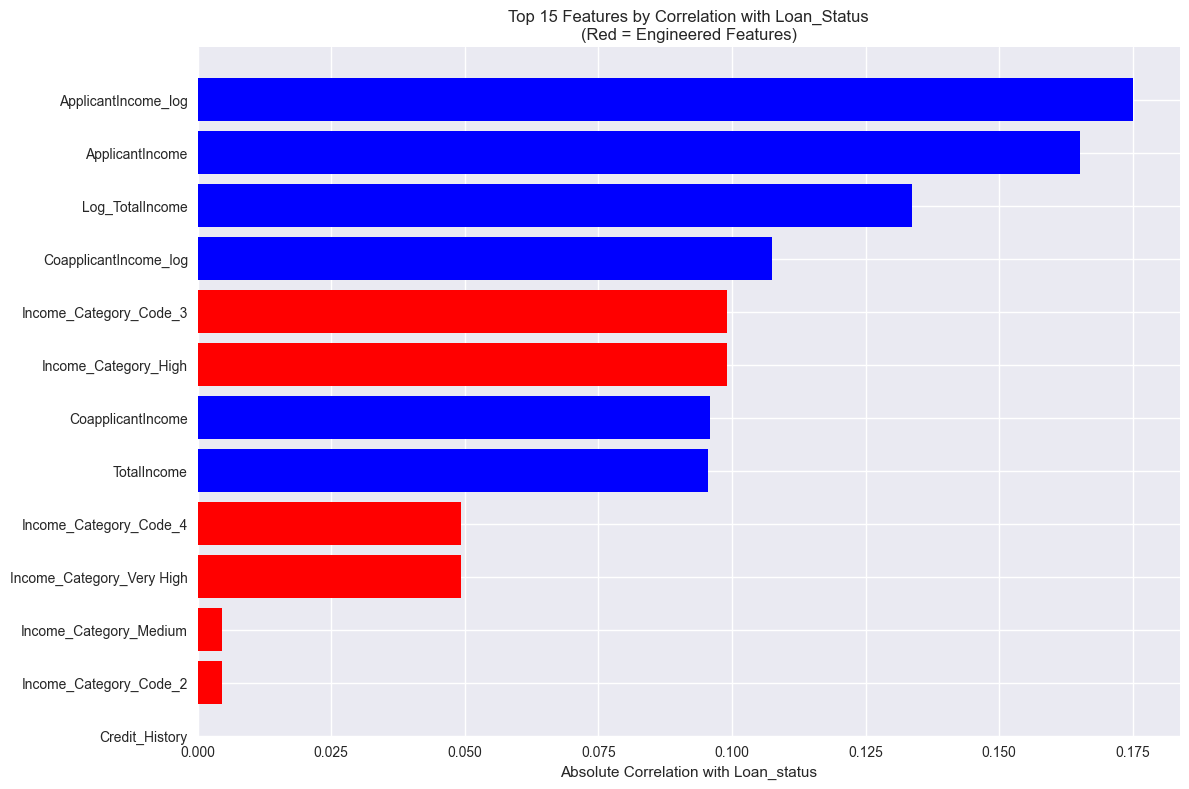


✓ Feature importance analysis completed
✓ 4 engineered features in top 10


In [18]:
# Feature importance analysis to validate EDA-based engineering
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Calculate correlation with target for all features
feature_correlations = X_train_scaled.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features by correlation with Loan_Status:")
for i, (feature, corr) in enumerate(feature_correlations.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Check if engineered features are among top features
engineered_features = [col for col in X_train_scaled.columns if any(keyword in col.lower() for keyword in ['object', 'category'])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in feature_correlations.head(10).index]}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_correlations.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['object', 'category']) else 'blue' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Loan_status')
plt.title('Top 15 Features by Correlation with Loan_Status\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in feature_correlations.head(10).index])} engineered features in top 10")


#### **11. Save Preprocessed Data**


Save all preprocessed datasets and preprocessing objects for modeling

In [19]:
print("SAVING PREPROCESSED DATA ")

# Save scaled datasets
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_val_scaled.to_csv('X_val_scaled.csv', index=False)
X_test_scaled.to_csv('X_test_scaled.csv', index=False)

# Save target variables
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

# Save feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_correlations.index,
    'correlation': feature_correlations.values
})
feature_importance_df.to_csv('feature_importance.csv', index=False)

# Save preprocessing summary
preprocessing_summary = {
    'original_shape': train_data.shape,
    'final_shape': t_processed.shape,
    'selected_features': selected_features,
    'engineered_features': engineered_features,
    'train_samples': X_train_scaled.shape[0],
    'val_samples': X_val_scaled.shape[0],
    'test_samples': X_test_scaled.shape[0],
    'scaling_method': 'StandardScaler',
    'outlier_treatment': 'IQR_capping',
    'log_transformed': ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
}

import json
with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
print("- y_train.csv, y_val.csv, y_test.csv")
print("- scaler.pkl, selected_features.pkl")
print("- feature_importance.csv, preprocessing_summary.json")


SAVING PREPROCESSED DATA 
- Preprocessed data saved successfully!

Files created:
- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
- y_train.csv, y_val.csv, y_test.csv
- scaler.pkl, selected_features.pkl
- feature_importance.csv, preprocessing_summary.json
